# Using Fourier transforms to do cross-correlation quicker (convolution)

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.signal

We've already mentioned that any time domain operation, such as the cross-correlations here, can be performed in the frequency domain. Let's illustrate this. We start again with our dataset and signal from the initial example in this lecture:

In [2]:
num_data_samples = 4096
sample_rate = 32
times = np.arange(num_data_samples) / sample_rate

gaussian_width = 5
signal_inst_frequency = 2. + 1.0*np.sin(2 * np.pi * 0.1 * times)
phases = [0]
for i in range(1,len(times)):
    phases.append(phases[-1] + 2 * np.pi * signal_inst_frequency[i] * 1./sample_rate)

signal = np.sin(phases)
gaussian = np.exp( - (times - 64)**2 / (2 * gaussian_width))
#print(len(signal),len(gaussian))
signal = signal * gaussian

noise = np.random.normal(size=[num_data_samples])*0.5

data = signal + noise


We also define our own Fourier transform code:

**YOU NEED TO ADD A FUNCTION INTO HERE. SEE PREVIOUS NOTEBOOKS. WHAT IS GOOD IF SPEED IS IMPORTANT?**

In [3]:
def compute_fourier_transform(data_time_domain):
    # FILL IN THE CODE HERE

def compute_inverse_fourier_transform(data_frequency_domain):
    # FILL IN THE CODE HERE


IndentationError: expected an indented block (3732622679.py, line 4)

In [4]:
# Sorry, this won't work for you, it's to build the web-page!
# Please use the cell above, instead.

from fourier_transform import compute_fourier_transform, compute_inverse_fourier_transform

We already saw that we can compute the cross correlation in the time domain:

In [5]:
print("Cross correlation of data and signal:", (data * signal).sum())
print("Cross correlation of noise and signal:", ((noise * signal).sum()))

Cross correlation of data and signal: 57.54833001200596
Cross correlation of noise and signal: -5.8649067680248415


We can also do the same in the Fourier domain

In [6]:
data_fdomain = compute_fourier_transform(data)
signal_fdomain = compute_fourier_transform(signal)
noise_fdomain = compute_fourier_transform(noise)

# np.conj is the complex conjugate, required to do this operation in frequency domain.
# Also note that we would need to renormalize the signal in the frequency domain if we want
# the cross correlation of noise and signal to follow a Gaussian with unit variance. I use the factor
# of num_data_samples here to get the same number in both cases!
print("Cross correlation of data and signal:", np.real((data_fdomain * np.conj(signal_fdomain)).sum()) / num_data_samples)
print("Cross correlation of noise and signal:", np.real((noise_fdomain * np.conj(signal_fdomain)).sum()) / num_data_samples)

Cross correlation of data and signal: 57.54833001200597
Cross correlation of noise and signal: -5.864906768024843


What's the benefit of this? Aren't we just putting in more effort to get the same number?

Indeed, if we are only computing one value, we don't need to worry about the Fourier domain, but if we want to compute the cross-correlation, *at many time points* it can be quicker. Remember that in the time domain, we simply had to compute the cross-correlation again and again for every time point? However, in the frequency domain a time-shift can be represented by $e^{i\pi f t}$ ... This is itself an \[inverse\] Fourier transform. Therefore we can quickly compute the cross correlation as a function of time by putting a Fourier transform into this:

The values at t=0 should be the same as above: 57.54833001200596 -5.864906768024842


Text(0.5, 0, 'Times (s)')

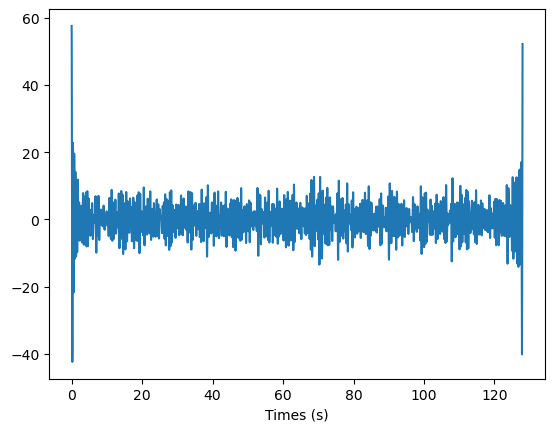

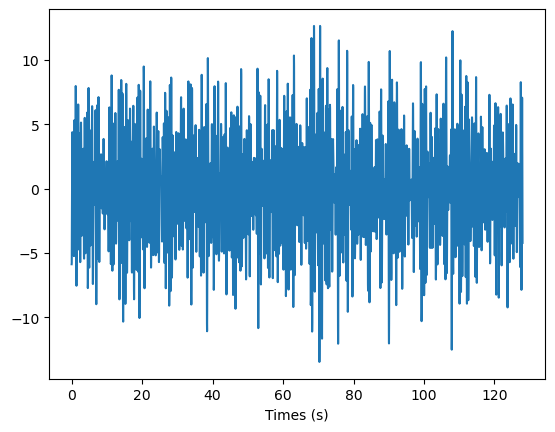

In [7]:
def compute_fdomain_crosscorr(data1, data2):
    multiple_data = data1 * np.conj(data2)
    tdomain_crosscorr = compute_inverse_fourier_transform(multiple_data)
    return np.real(tdomain_crosscorr)


data_signal_crosscorr = compute_fdomain_crosscorr(data_fdomain, signal_fdomain)
noise_signal_crosscorr = compute_fdomain_crosscorr(noise_fdomain, signal_fdomain)

print("The values at t=0 should be the same as above:", data_signal_crosscorr[0], noise_signal_crosscorr[0])

plt.figure()
plt.plot(times, data_signal_crosscorr)
plt.xlabel('Times (s)')

plt.figure()
plt.plot(times, noise_signal_crosscorr)
plt.xlabel('Times (s)')


This is a much quicker way of computing a cross-correlation at multiple times. However, there are a number of subtleties here. Lets deal with them one-by-one.

* Why is the peak of the cross-correlation at t=0, when the signal was in the middle?

The answer to that is that the signal we cross-correlated with did not have its peak at t=0 and so the obtained plot above is offset in time. Or in technical terms this is not a "zero-phase" filter. To correct this we need to put the peak of the waveform at the start. REMEMBER: In the frequency domain time series wrap around so that the start is connected to the end:

Text(0.5, 0, 'Times (s)')

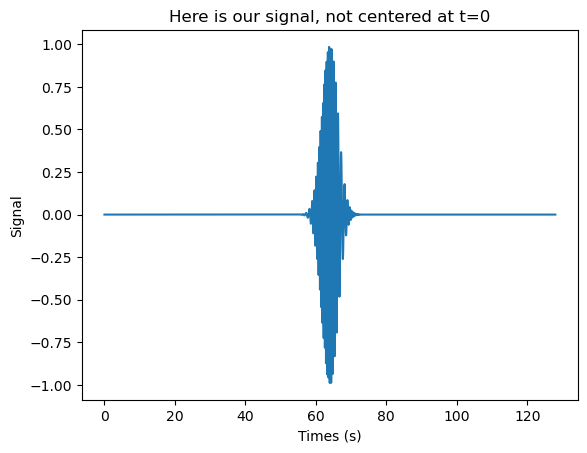

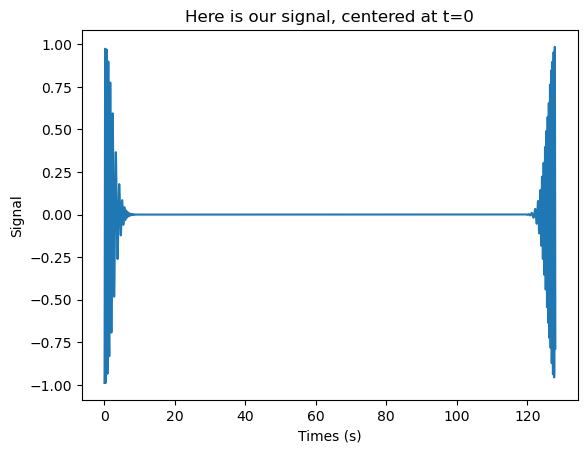

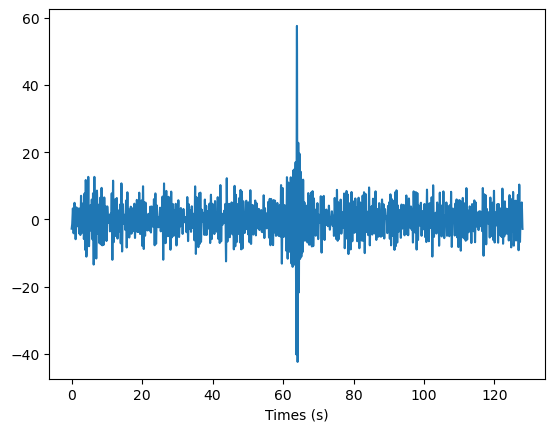

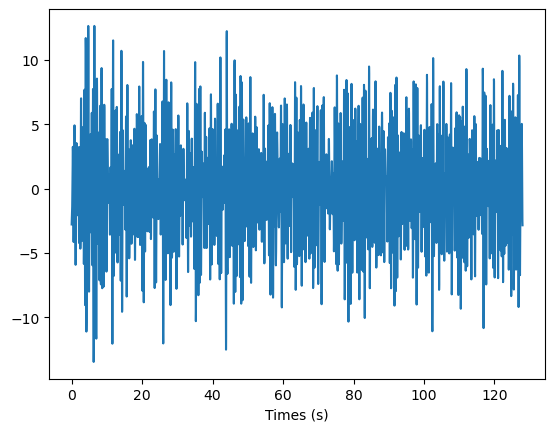

In [8]:
plt.figure()
plt.title("Here is our signal, not centered at t=0")
plt.plot(times, signal)
plt.xlabel('Times (s)')
plt.ylabel('Signal')

# Identify peak of the signal
max_time = np.argmax(abs(signal))
# And shift the signal
shifted_signal = np.roll(signal, -max_time)

plt.figure()
plt.title("Here is our signal, centered at t=0")
plt.plot(times, shifted_signal)
plt.xlabel('Times (s)')
plt.ylabel('Signal')

# And Fourier transform
shifted_signal_fdomain = compute_fourier_transform(shifted_signal)

# And cross-correlate again:
data_signal_crosscorr = compute_fdomain_crosscorr(data_fdomain, shifted_signal_fdomain)
noise_signal_crosscorr = compute_fdomain_crosscorr(noise_fdomain, shifted_signal_fdomain)

plt.figure()
plt.plot(times, data_signal_crosscorr)
plt.xlabel('Times (s)')

plt.figure()
plt.plot(times, noise_signal_crosscorr)
plt.xlabel('Times (s)')



Okay, so now the peak in our time series is in the same place as the signal. Let's worry about the next concern:

* The length of the data and the length of the signal waveform must be the same.

In most cases you might be searching for quite a short signal in a long stretch of data. There's two ways to deal with this problem:

 1. Perform the cross-correlation repeatedly on short stretches of data, and join these together to get the cross-correlation over the whole data set.
 1. Make the signal waveform longer (by padding with zeroes).

The second solution might be simpler, but it significantly increases the computational cost. In many real-world examples the first approach must be used. This is also linked to our third concern.

* As with our high-pass filter example from before we still assume that the data is cyclical. This can introduce a discontinuity into the data and make the cross-correlation invalid whenever it overlaps this region.

Let's try and illustrate this last problem by using a different data set, where we are not using white noise and the data is not cyclical:

Text(0.5, 0, 'Times (s)')

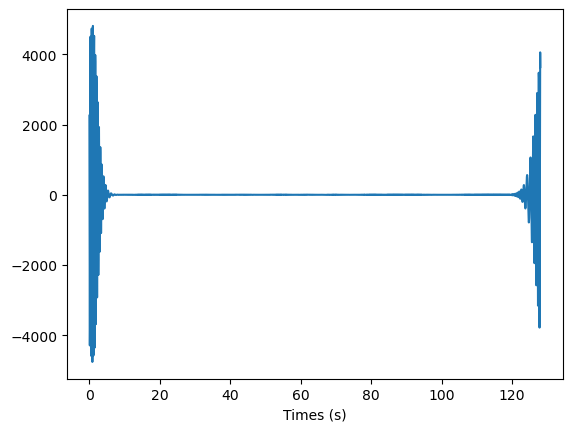

In [9]:
times_4096 = np.arange(4096*32) / 32
data_time_domain_TMP = np.zeros(4096*32)
# Add some narrow range mid-frequency noise
for i in range(4*4096,4*4096+1000):
    omega = i / 4096. * (2*np.pi)
    phase=np.random.random() * (2*np.pi)
    data_time_domain_TMP += 100*np.sin(times_4096 * omega + phase)


low_freq_noise = data_time_domain_TMP[23:4096+23]

low_freq_noise_fdomain = compute_fourier_transform(low_freq_noise)

lf_noise_signal_crosscorr = compute_fdomain_crosscorr(low_freq_noise_fdomain, shifted_signal_fdomain)

plt.figure()
plt.plot(times, lf_noise_signal_crosscorr)
plt.xlabel('Times (s)')


Here we can see huge values of the cross-correlation at both ends. This is where the signal waveform is matched against the join between the end and the start of the data. This is not physical. In this case values at the start and the end should be discarded. The length of data discarded should be equal to the length of the signal waveform.